# Constrained Orthogonal Matching Pursuit for Audio Declipping

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import cvxpy as cp
from IPython.display import Audio
from tqdm import tqdm

import soundfile as sf 
import librosa 
import os

## Signal Clipping

In [5]:
def clip(s, theta_clip : float):
    """ 
    Clips a signal s to the range [-theta_clip, theta_clip]
    """
    return np.clip(s, -theta_clip, theta_clip)

In [6]:
def get_theta_clip(y):
    """ 
    Returns the clipping threshold for a clipped signal y
    """
    return np.max(np.abs(y))

In [7]:
def get_M_r(y, theta_clip : float = None):
    """
    Returns the measurement matrix M_r for a clipped signal y
    s.t y_r = M_r * s
    """
    N = y.shape[0]
    M_r = np.eye(N)
    theta_clip = theta_clip if theta_clip is not None else get_theta_clip(y) 
    I_r = np.abs(y) < theta_clip           
    M_r = M_r[I_r, :]
    return M_r

In [8]:
def get_M_m(y, theta_clip : float = None):
    """""
    Returns the matrix M_m for a clipped signal y
    s.t y_m = M_m * sign(s) * s (complement of M_r)
    """""
    N = y.shape[0]
    M_m = np.eye(N)
    theta_clip = theta_clip if theta_clip is not None else get_theta_clip(y) 
    I_m = np.abs(y) >= theta_clip
    M_m = M_m[I_m, :]
    return M_m

In [9]:
def get_M_m_plus(y, theta_clip : float = None):
    """
    Returns the matrix M_m_plus (which gives the indices at which the signal is clipped from above) for a clipped signal y
    """
    N = y.shape[0]
    M_m_plus = np.eye(N)
    theta_clip = theta_clip if theta_clip is not None else get_theta_clip(y) 
    I_m_plus = y >= theta_clip           
    M_m_plus = M_m_plus[I_m_plus, :]
    return M_m_plus

In [10]:
def get_M_m_minus(y, theta_clip : float = None):
    """
    Returns the matrix M_m_minus (which gives the indices at which the signal is clipped from below) for a clipped signal y
    """
    N = y.shape[0]
    M_m_minus = np.eye(N)
    theta_clip = theta_clip if theta_clip is not None else get_theta_clip(y) 
    I_m_minus = y <= -theta_clip           
    M_m_minus = M_m_minus[I_m_minus, :]
    return M_m_minus

## Dictionaries

In [11]:
params = {
    "sampling_rate": 16000,
    "frame_length": 1024,
    "frame_overlap": 768
}

# Number of atoms per dictionary
K_g = params["frame_length"]//2
# Length of the signal
N = params["frame_length"]

In [12]:
def get_gabor_dictionaries(N : int, K_g : int, weight_window : np.ndarray = np.ones((N, K_g))):
    # Create the time-frequency grid
    T = np.arange(0, N)
    J = np.arange(0, K_g)
    J, T = np.meshgrid(J, T)

    # Dictionaries of shape (N, K_g), 2* K_g atoms in total
    gabor_cosine = weight_window * np.cos(np.pi * (J+1/2) * (T+1/2) / K_g)
    gabor_sine = weight_window * np.sin(np.pi * (J+1/2) * (T+1/2) / K_g)

    return gabor_cosine, gabor_sine

In [13]:
gabor_cosine, gabor_sine = get_gabor_dictionaries(N, K_g)

In [14]:
gabor_cosine.shape, gabor_sine.shape

((1024, 512), (1024, 512))

## Orthogonal Matching Pursuit

In [15]:
def least_squares(y : np.ndarray, M_r : np.ndarray, Omega : list, D_c : np.ndarray, D_s : np.ndarray, W_c : np.ndarray, W_s : np.ndarray,
                  theta_clip : float = None, theta_max : float = None, M_m_plus : np.ndarray = None, M_m_minus : np.ndarray = None, lambda_reg : float = 0, verbose : bool = False):
    """
    Solves the following least squares problem
        min_{x_c, x_s} ||y - D_c * x_c - D_s * x_s||^2 + lambda * ||x_c||^2 + lambda * ||x_s||^2     s.t.     ...

    Inputs:
    -------
    y : np.ndarray
        The signal to be reconstructed
    M_r : np.ndarray
        The measurement matrix
    Omega : list
        The indices of the measurements
    D_c : np.ndarray
        The dictionary of cosine atoms
    D_s : np.ndarray
        The dictionary of sine atoms
    W_c : np.ndarray
        The window function for the cosine atoms
    W_s : np.ndarray
        The window function for the sine atoms
    theta_clip : float
        The clipping threshold
    theta_max : float
        The maximum amplitude of the signal
    M_m_plus : np.ndarray
        The matrix M_m_plus
    M_m_minus : np.ndarray
        The matrix M_m_minus
    lambda_reg : float
        The regularization parameter

    Outputs:
    --------
    x_c : np.ndarray
        The coefficients of the cosine atoms
    x_s : np.ndarray
        The coefficients of the sine atoms
    """
    y_r = M_r @ y
    D = np.concatenate(((D_c @ W_c)[:,Omega], (D_s @ W_s)[:,Omega]), axis=1)
    D_r = M_r @ D

    if theta_clip is not None or theta_max is not None or lambda_reg > 0.:
        if M_m_plus is None:
            M_m_plus = get_M_m_plus(y, theta_clip)
        if M_m_minus is None:
            M_m_minus = get_M_m_minus(y, theta_clip)

        x = cp.Variable(D_r.shape[1])
        obj = cp.Minimize(cp.sum_squares(y_r - D_r @ x) + lambda_reg * cp.sum_squares(x))
        
        constraints = []
        if theta_clip is not None:      # Min constraints
            if len(M_m_plus) > 0:
                constraints += [M_m_plus @ D @ x >= theta_clip]
            if len(M_m_minus) > 0:
                constraints += [M_m_minus @ D @ x <= - theta_clip]
        if theta_max is not None:       # Max constraints
            if len(M_m_plus) > 0:
                constraints += [M_m_plus @ D @ x <= theta_max]
            if len(M_m_minus) > 0:
                constraints += [M_m_minus @ D @ x >= - theta_max]

        prob = cp.Problem(obj, constraints)
        prob.solve()
        if prob.status == 'infeasible':
            if verbose:
                print("Infeasible problem")
            x = np.linalg.lstsq(D, y, rcond=None)[0]
        else:
            if verbose:
                print('Constrained problem solved')
            x = x.value

    else:
        x = np.linalg.lstsq(D, y, rcond=None)[0]

    x_c = x[:D_c[:,Omega].shape[1]]
    x_s = x[D_c[:,Omega].shape[1]:]
    return x_c, x_s

In [16]:
def OMP(y : np.ndarray, K : int, eps : float, 
        D_c : np.ndarray = gabor_cosine, D_s : np.ndarray = gabor_sine, theta_clip : float = None, theta_max : float = None, verbose : bool = True, lambda_reg : float = 0):
    """ 
    Runs the Orthogonal Matching Pursuit algorithm, using Gabor Dictionaries.

    Inputs:
    --------
    y: np.array
        Input signal of size N
    K: int
        Maximal number of atoms to select
    eps: float
        Stopping criterion
    D_c: np.array
        Dictionary for the cosine atoms of size (N, K_g)
    D_s: np.array
        Dictionary for the sine atoms of size (N, K_g)
    theta_clip: float
        Clipping value of the signal, used as an additional constraint in the least squares problem. If None, no clipping constraint is applied.
    theta_max: float
        Maximum value of the signal, used as an additional constraint in the least squares problem. If None, no maximum constraint is applied.
    verbose: bool
        If True, prints the residual norm at each iteration

    Outputs:
    --------
    y_reconstructed: np.array
        Reconstruction of the original signal y
    x_c: np.array
        Sparse activations of the cosine atoms 
    x_s: np.array
        Sparse activations of the sine atoms
    residual_norms : list
        List of the squared norms of the residuals at each iteration
    """

    K_g = D_c.shape[1]

    # Partition the samples of the signal
    M_r = get_M_r(y, theta_clip)                                           # Of shape (N_r, N)
    M_m_plus = get_M_m_plus(y, theta_clip) if theta_clip is not None else None
    M_m_minus = get_M_m_minus(y, theta_clip) if theta_clip is not None else None

    # Reliable samples of the signal
    y_r = M_r @ y                                                          # Of shape (N_r)

    # Dictionaries
    W_c = np.diag(1 / np.linalg.norm(M_r @ D_c, axis=0))                   # W_j,j = 1/||M_r * d_j||, j = 0, ..., K_g-1, of shape (K_g, K_g)
    W_s = np.diag(1 / np.linalg.norm(M_r @ D_s, axis=0))
    d_c_norm = M_r @ D_c @ W_c                                             # Of shape (N_r, K_g)
    d_s_norm = M_r @ D_s @ W_s

    # Array containing <d_norm_j^c|d_norm_j^s>, j = 0, ..., K_g-1, of shape (K_g)
    d_cs_dot = np.zeros(K_g)
    for j in range(K_g):
        d_cs_dot[j] = np.dot(d_c_norm[:,j], d_s_norm[:,j])

    # Residual and support
    r = y_r
    Omega = []
    residual_norms = [np.linalg.norm(y_r)**2]


    for k in range(K):

        # Atom selection
        x_c = (np.dot(r, d_c_norm) - d_cs_dot * np.dot(r, d_s_norm)) / (1 - d_cs_dot**2)
        x_s = (np.dot(r, d_s_norm) - d_cs_dot * np.dot(r, d_c_norm)) / (1 - d_cs_dot**2)
        proj = np.zeros(K_g)
        for j in range(K_g):
            if j not in Omega:
                proj[j] = np.linalg.norm(r - x_c[j] * d_c_norm[:,j] - x_s[j] * d_s_norm[:,j])**2
            else:
                proj[j] = np.inf          # Do not choose j if it is already in Omega
        i = np.argmin(np.abs(proj))

        # Update support and residual
        Omega.append(i)
        x_c2, x_s2 = least_squares(y, M_r = M_r, Omega = Omega, D_c = D_c, D_s = D_s, W_c = W_c, W_s = W_s, M_m_plus = M_m_plus, M_m_minus = M_m_minus, verbose = verbose)
        x_c, x_s = np.zeros(K_g), np.zeros(K_g)
        x_c[Omega] = x_c2
        x_s[Omega] = x_s2

        r = y_r - np.dot(d_c_norm[:,Omega], x_c2) - np.dot(d_s_norm[:,Omega], x_s2)
        r_norm = np.linalg.norm(r)**2
        residual_norms.append(r_norm)

        if verbose:
            print(f"Iteration {k}: residual norm {r_norm:.5f}.")

        # Stopping criterion
        if r_norm < eps:
            if verbose:
                print(f"Stopping criterion reached before selecting {K} atoms")
            break
    
    # Output
    x_c2, x_s2 = least_squares(y, M_r = M_r, Omega = Omega, D_c = D_c, D_s = D_s, W_c = W_c, W_s = W_s,
                               M_m_plus = M_m_plus, M_m_minus = M_m_minus, theta_clip = theta_clip, theta_max = theta_max, lambda_reg = lambda_reg)
    x_c, x_s = np.zeros(K_g), np.zeros(K_g)
    x_c[Omega] = x_c2
    x_s[Omega] = x_s2
    x_c = W_c @ x_c
    x_s = W_s @ x_s
    y_reconstructed = D_c @ x_c + D_s @ x_s

    return y_reconstructed, x_c, x_s, residual_norms

In [17]:
def inpainting(y, frame_length : int = 1024, frame_overlap : int = 768, K : int = 50, eps : float = 1e-6,
               D_c : np.ndarray = gabor_cosine, D_s : np.ndarray = gabor_sine, theta_clip : float = None, theta_max : float = None):
    """
    Segments a signal y into overlapping frames of length frame_length and overlap frame_overlap
    Then runs OMP on each frame to inpaint the missing samples
    Then reconstructs the signal using OLA
    Remark : Ensure a 75% overlap between the frames and 1024 points per frame

    Inputs:
    -------
    y: np.array
        Input signal of size N
    frame_length: int  
        Length of the frames   
    frame_overlap: int
        Overlap between the frames
    K: int
        Maximal number of atoms to select
    eps: float
        Stopping criterion
    D_c: np.array
        Dictionary for the cosine atoms of size (N, K_g)
    D_s: np.array
        Dictionary for the sine atoms of size (N, K_g)
    theta_clip: float
        Clipping value of the signal, used as an additional constraint in the least squares problem. If None, no clipping constraint is applied.
    theta_max: float
        Maximum value of the signal, used as an additional constraint in the least squares problem. If None, no maximum constraint is applied.
    
    Outputs:
    --------
    y_reconstructed: np.array
        Reconstruction of the original signal y using the sparse activations of the atoms
    """
    
    N = len(y)
    w_a = sig.windows.boxcar(frame_length) # Analysis window
    w_s = np.sin(np.pi * np.arange(frame_length) / (frame_length - 1)) # Synthesis window
    w_s /= np.sum(w_s) # Normalize the synthesis window so that \sum w_s w_a = 1
    t_i_s = np.arange(0, N - frame_length + 1, frame_length - frame_overlap) # Frames starting dates
    theta_clip = theta_clip if theta_clip is not None else get_theta_clip(y)

    y_reconstructed = np.zeros(N)

    for i in tqdm(t_i_s):
        y_i = w_a * y[i:i+frame_length]
        N_r = len(get_M_r(y_i, theta_clip)) # Number of reliable samples in the frame
        if N_r == frame_length:                   # Don't run OMP if the frame is not clipped
            y_reconstructed[i:i+frame_length] +=  w_s * y_i
        else:
            y_i_reconstructed, x_c_i, x_s_i, _ = OMP(y_i, K, eps*N_r, D_c, D_s, theta_clip = theta_clip, theta_max = theta_max, verbose = False)
            y_reconstructed[i:i+frame_length] += w_s * y_i_reconstructed

    return y_reconstructed

In [18]:
def inpainting_rectangle(y, frame_length : int = 1024, frame_overlap : int = 768, K : int = 50, eps : float = 1e-6,
               D_c : np.ndarray = gabor_cosine, D_s : np.ndarray = gabor_sine, theta_clip : float = None, theta_max : float = None):
    """
    Segments a signal y into overlapping frames of length frame_length and overlap frame_overlap
    Then runs OMP on each frame to inpaint the missing samples
    Then reconstructs the signal using OLA
    Remark : Ensure a 75% overlap between the frames and 1024 points per frame

    Inputs:
    -------
    y: np.array
        Input signal of size N
    frame_length: int  
        Length of the frames   
    frame_overlap: int
        Overlap between the frames
    K: int
        Maximal number of atoms to select
    eps: float
        Stopping criterion
    D_c: np.array
        Dictionary for the cosine atoms of size (N, K_g)
    D_s: np.array
        Dictionary for the sine atoms of size (N, K_g)
    theta_clip: float
        Clipping value of the signal, used as an additional constraint in the least squares problem. If None, no clipping constraint is applied.
    theta_max: float
        Maximum value of the signal, used as an additional constraint in the least squares problem. If None, no maximum constraint is applied.
    
    Outputs:
    --------
    y_reconstructed: np.array
        Reconstruction of the original signal y using the sparse activations of the atoms
    """
    
    N = len(y)
    w_a = sig.windows.boxcar(frame_length) # Analysis window
    w_s = np.sin(np.pi * np.arange(frame_length) / (frame_length - 1)) # Synthesis window
    t_i_s = np.arange(0, N - frame_length + 1, frame_length - frame_overlap) # Frames starting dates
    theta_clip = theta_clip if theta_clip is not None else get_theta_clip(y)

    y_reconstructed = np.zeros(N)
    y_count = np.zeros(N)

    for i in tqdm(t_i_s):
        y_i = w_a * y[i:i+frame_length]
        y_count[i:i+frame_length] += 1
        N_r = len(get_M_r(y_i, theta_clip)) # Number of reliable samples in the frame
        if N_r == frame_length:                   # Don't run OMP if the frame is not clipped
            y_reconstructed[i:i+frame_length] += y_i # w_s * y_i
        else:
            y_i_reconstructed, x_c_i, x_s_i, _ = OMP(y_i, K, eps*N_r, D_c, D_s, theta_clip = theta_clip, theta_max = theta_max, verbose = False)
            y_reconstructed[i:i+frame_length] += y_i_reconstructed # w_s * y_i_reconstructed

    return y_reconstructed, y_count

## Data

### Synthetic Dataset

In [65]:
# Synthetic data generation
# TODO: Modifier la maniere dont choisir les coefficients
def generate_synthetic_dataset(M, N, K, theta_clip : float = .8, D_c = gabor_cosine, D_s = gabor_sine, sigma : float = 0.1):
    """
    Generates M waveforms of length N. Each waveform is a sum of K Gabor atoms and some noise. Both the original signal and the signal clipped at theta_clip are returned, along with the grounD-truth vector x.
    """
    K_g = D_c.shape[1]

    X = np.zeros((M, 2*K_g))
    Y = np.zeros((M, N))
    Y_clipped = np.zeros((M, N))

    for i in range(M):
        y = np.zeros(N)
        for k in range(K):
            j = np.random.randint(0, K_g//4)
            a = .2 * np.random.randn()
            b = .2 * np.random.randn()
            y += a * D_c[:,j] + b * D_s[:,j]
            X[i, j] += a
            X[i, K_g+j] += b
        Y[i] = y + sigma * np.random.randn(N)
        Y_clipped[i] = clip(Y[i], theta_clip)
    
    return X, Y, Y_clipped


In [66]:
y, sr = librosa.load('processed_sounds/trumpet/3_kanye.wav', sr=params["sampling_rate"])
y

array([ 0.10699463,  0.18334961,  0.3050537 , ..., -0.08331299,
       -0.11608887, -0.1204834 ], dtype=float32)

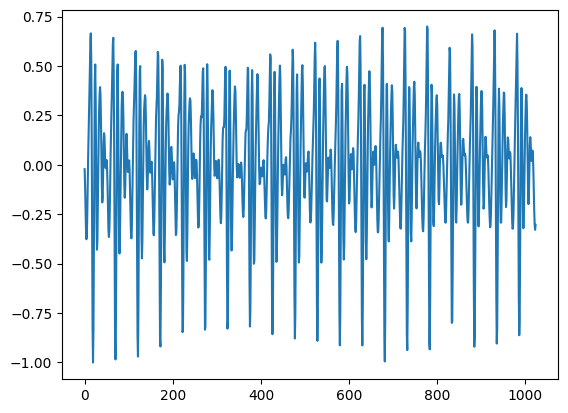

In [67]:
start_frame = 300000
y_frame = y[start_frame:start_frame+1024]
y_frame = y_frame / np.max(np.abs(y_frame))
plt.plot(y_frame)

In [68]:
Audio(y_frame, rate = sr)

In [69]:
y_clipped = clip(y_frame, 0.5)

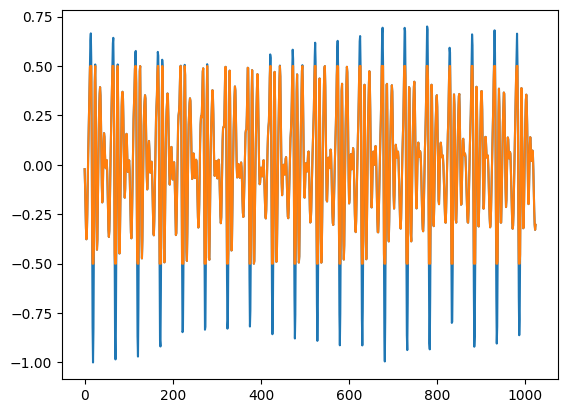

In [70]:
plt.plot(y_frame)
plt.plot(y_clipped)


In [71]:
Audio(y_clipped, rate = sr)

In [72]:
y_reconstructed = OMP(y_clipped, 200, 1e-6, theta_clip = .5, theta_max = 1.2, lambda_reg = 0.)[0]

Iteration 0: residual norm 34.87994.
Iteration 1: residual norm 27.12773.
Iteration 2: residual norm 18.61453.
Iteration 3: residual norm 14.41691.
Iteration 4: residual norm 10.48806.
Iteration 5: residual norm 7.97327.
Iteration 6: residual norm 6.65824.
Iteration 7: residual norm 5.45466.
Iteration 8: residual norm 4.81071.
Iteration 9: residual norm 4.26298.
Iteration 10: residual norm 4.00106.
Iteration 11: residual norm 3.76755.
Iteration 12: residual norm 3.58979.
Iteration 13: residual norm 3.42416.
Iteration 14: residual norm 3.26073.
Iteration 15: residual norm 3.10689.
Iteration 16: residual norm 2.97700.
Iteration 17: residual norm 2.86047.
Iteration 18: residual norm 2.78744.
Iteration 19: residual norm 2.68801.
Iteration 20: residual norm 2.59954.
Iteration 21: residual norm 2.48749.
Iteration 22: residual norm 2.41435.
Iteration 23: residual norm 2.33768.
Iteration 24: residual norm 2.26010.
Iteration 25: residual norm 2.18226.
Iteration 26: residual norm 2.11669.
Iterat

In [81]:
y_reconstructed_L2 = OMP(y_clipped, 200, 1e-6, theta_clip = .5, theta_max = 1.2, lambda_reg = 0.0001)[0]

Iteration 0: residual norm 34.87994.
Iteration 1: residual norm 27.12773.
Iteration 2: residual norm 18.61453.
Iteration 3: residual norm 14.41691.
Iteration 4: residual norm 10.48806.
Iteration 5: residual norm 7.97327.
Iteration 6: residual norm 6.65824.
Iteration 7: residual norm 5.45466.
Iteration 8: residual norm 4.81071.
Iteration 9: residual norm 4.26298.
Iteration 10: residual norm 4.00106.
Iteration 11: residual norm 3.76755.
Iteration 12: residual norm 3.58979.
Iteration 13: residual norm 3.42416.
Iteration 14: residual norm 3.26073.
Iteration 15: residual norm 3.10689.
Iteration 16: residual norm 2.97700.
Iteration 17: residual norm 2.86047.
Iteration 18: residual norm 2.78744.
Iteration 19: residual norm 2.68801.
Iteration 20: residual norm 2.59954.
Iteration 21: residual norm 2.48749.
Iteration 22: residual norm 2.41435.
Iteration 23: residual norm 2.33768.
Iteration 24: residual norm 2.26010.
Iteration 25: residual norm 2.18226.
Iteration 26: residual norm 2.11669.
Iterat

In [82]:
((y_frame - y_reconstructed)**2).sum()/1024

0.0003744782924502618

In [83]:
((y_frame - y_reconstructed_L2)**2).sum()/1024

0.0008792188662247709

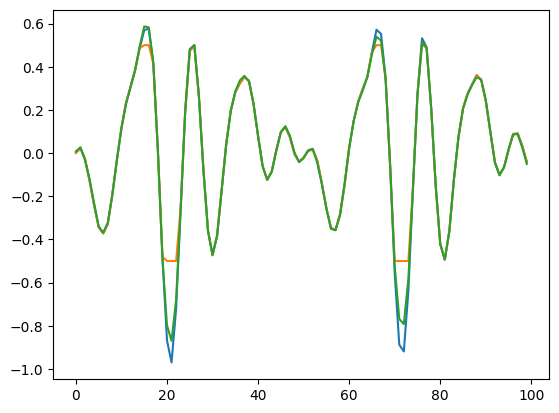

In [84]:
plt.plot(y_frame[100:200])
plt.plot(y_clipped[100:200])
plt.plot(y_reconstructed[100:200])


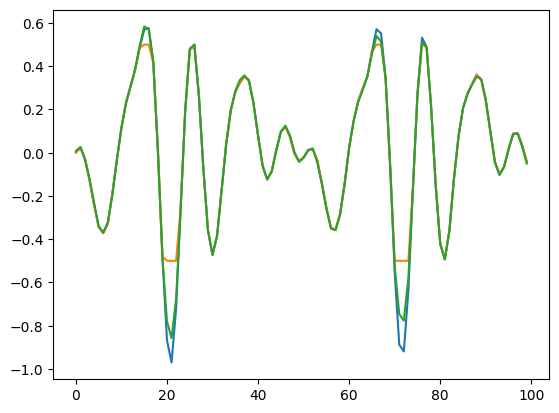

In [85]:
plt.plot(y_frame[100:200])
plt.plot(y_clipped[100:200])
plt.plot(y_reconstructed_L2[100:200])


In [87]:
Audio(y_reconstructed, rate = sr)

In [49]:
Audio(y_frame, rate = sr)

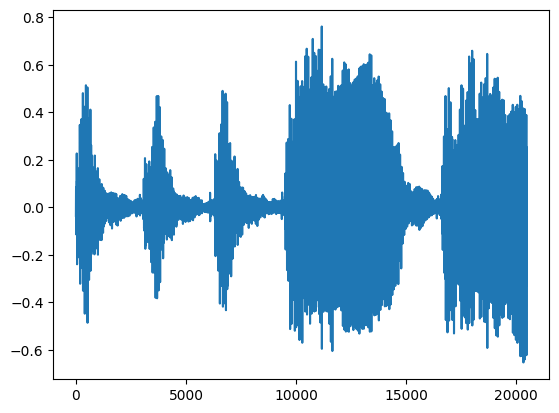

In [75]:
start = 10000
y_10secs = y[start:start+20*1024]
plt.plot(y_10secs)

In [76]:
Audio(y_10secs, rate = sr)

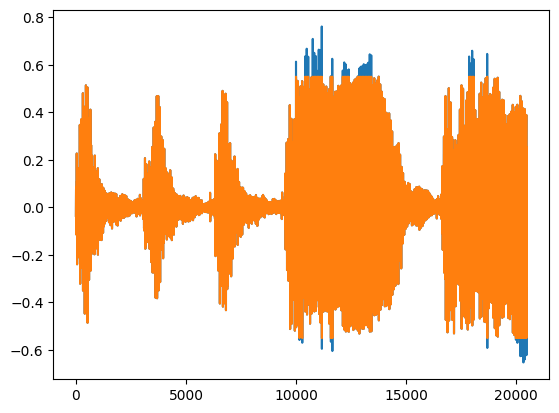

In [94]:
y_clipped = clip(y_10secs, 0.55)
plt.plot(y_10secs)
plt.plot(y_clipped)

In [95]:
Audio(y_10secs, rate = sr)

In [96]:
Audio(y_clipped, rate = sr)

In [195]:
y_reconstructed = inpainting(y_clipped)

100%|██████████| 77/77 [01:20<00:00,  1.04s/it]


In [199]:
y_reconstructed, y_counts = y_reconstructed

In [200]:
Audio(y_reconstructed, rate = sr)

4.0

In [205]:
y_10secs

array([-0.03552246,  0.00765991,  0.03988647, ...,  0.04547119,
        0.09848022,  0.12902832], dtype=float32)

In [206]:
y_reconstructed

array([-0.03552246,  0.00765991,  0.03988647, ...,  0.15048753,
        0.19420578,  0.20872012])

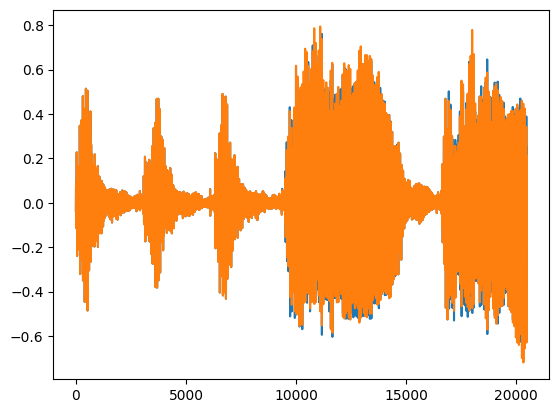

In [204]:
plt.plot((y_10secs))
plt.plot((y_reconstructed/y_counts))


### Real Datasets

We use two datasets.

- LJSpeech-1.1 originally include thousands of <10 seconds speech extracts (people reading passages of books). These are sampled at 22050 Hz. We only retained 20 of these .wav files.

- Solo, which includes audio recordings of instruments playing songs, sampled at 44100 Hz. These are divided in 8 classes (accordion, acoustic_guitar, cello, flute, saxophone, trumpet, violin, xylophone) and are of variable length. We retained 2 or three recordings per instrument (several minutes of music for each instrument).

#### Exploratory Data Analysis

In [23]:
#audio_path = 'solo/accordion/1.wav'
#data, sample_rate = sf.read(audio_path)
#Audio(audio_path)

In [24]:
#print("We have", len(data), "points.")
#print("The sampling rate is : ", sample_rate, "Hz.")

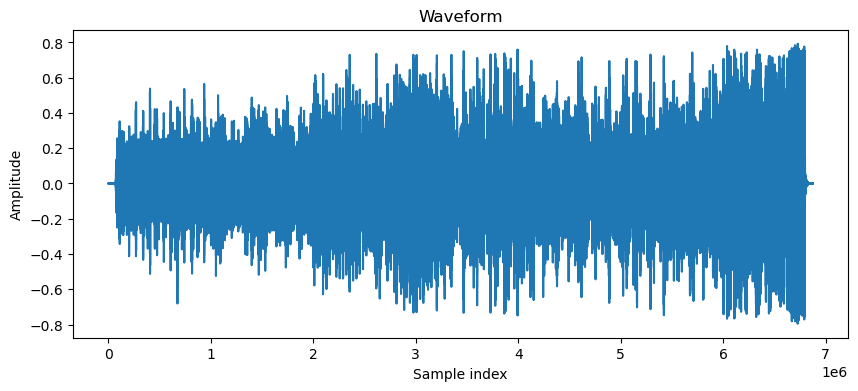

In [18]:
plt.figure(figsize=(10, 4))
plt.plot(data)
plt.title('Waveform')
plt.xlabel('Sample index')
plt.ylabel('Amplitude')
plt.show()

### Preprocessing : 
1 - Downsample each file to 16kHz.

2 - Trim the silence at the beginning and end of the files.

3 - Normalize the amplitudes so that the max of each signal equals to 1

4 - Shorten the signals so that their length is a multiple of frame_length (1024)

In [122]:
def preprocess_wav(file_path, output_path, target_sample_rate=16000, silence_threshold=0.1):
    """
    Preprocess a single wav file:
    1. Resample it to 16kHz
    2. Remove silence from the beginning and end
    3. Normalize the amplitude to [0,1]
    4. Save the result to the output path
    """
    # 1 : Load the audio file
    data, sr = librosa.load(file_path, sr=None)  # Load with original sample rate
    print(f"Original Sample Rate: {sr}, Target Sample Rate: {target_sample_rate}")
    
    # 2 : Resample
    if sr != target_sample_rate:
        data = librosa.resample(data, orig_sr=sr, target_sr=target_sample_rate)
    
    # 3 : Remove silence from the beginning and end
    non_silent_indices = np.where(np.abs(data) > silence_threshold)[0]
    
    if len(non_silent_indices) > 0:  # Ensure there is non-silent audio
        start_index = non_silent_indices[0]
        end_index = non_silent_indices[-1]
        data = data[start_index:end_index + 1]
    else:
        print(f"Warning: No non-silent audio found in {file_path}")
    
    # 4 : Normalize the amplitude to [0,1]
    data = data / np.max(abs(data))

    # 5 : make sure that the data is a multiple of the frame length
    frame_length = 1024
    num_frames = len(data) // frame_length
    new_length = num_frames * frame_length
    data = data[:new_length]

    # 6 : Save the processed audio to the output directory
    sf.write(output_path, data, target_sample_rate)
    print(f"Processed file saved to {output_path}")

In [131]:
input_dir = 'LJSpeech-1.1/wavs/'
output_dir = 'processed_sounds/speech/'
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(input_dir):
    if filename.endswith('.wav'): 
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)
        
        print(f"Processing {filename}...")
        preprocess_wav(input_path, output_path)

Processing 1.wav...
Original Sample Rate: 44100, Target Sample Rate: 16000
Processed file saved to processed_sounds/accordion/1.wav
Processing 2.wav...
Original Sample Rate: 44100, Target Sample Rate: 16000
Processed file saved to processed_sounds/accordion/2.wav


#### Example :

In [15]:
file_path_crude = "solo/acoustic_guitar/4.wav"
file_path_processed = "processed_sounds/acoustic_guitar/4.wav"
data_crude, sample_rate_crude = sf.read(file_path_crude)
data_processed, sample_rate_processed = sf.read(file_path_processed)

print("Crude audio file:")
print(len(data_crude), "points  ", sample_rate_crude, "Hz")
print("Processed audio file:")
print(len(data_processed), "points  ", sample_rate_processed, "Hz")

Crude audio file:
9863168 points   44100 Hz
Processed audio file:
3483648 points   16000 Hz


In [25]:
#audio_path = 'processed_sounds/xylophone/3.wav'
#data, sample_rate = sf.read(audio_path)
#Audio(audio_path) 

## Experiments

In [222]:
# Idees
## SNR_m vs theta_clip
## SNR_m vs K ? 
## SNR_m vs SDR
## Impact of lambda_reg ?
## Performance on music vs Speech /// vs different instruments
## Inpainting performance on 3_Kanye.wav


In [20]:
def compute_SNR_m(y, y_reconstructed, theta_clip : float = None):
    """
    Computes the Signal to Noise Ratio between the original signal y and the reconstructed signal y_reconstructed
    on the missing samples
    """
    
    M_m = get_M_m(y, theta_clip)
    y_m = M_m @ y
    y_reconstructed_m = M_m @ y_reconstructed
    return 10 * np.log10(np.linalg.norm(y_m)**2 / np.linalg.norm(y_m - y_reconstructed_m)**2)

def compute_SNR_full(y, y_reconstructed, theta_clip : float = None):
    """
    Computes the Signal to Noise Ratio between the original signal y and the reconstructed signal y_reconstructed
    on the full signal
    """
    M_m = get_M_m(y, theta_clip)
    y_m = M_m @ y
    return compute_SNR_m(y, y_reconstructed, theta_clip) + 10 * np.log10(np.linalg.norm(y)**2 / np.linalg.norm(y_m)**2)

def compute_SDR(y, y_cliped, theta_clip : float = None):
    """
    Computes the Signal to Distortion Ratio between the original signal y and the cliped signal y_distorted
    """
    return 10 * np.log10(np.linalg.norm(y)**2 / np.linalg.norm(y - y_cliped)**2)


### Illustration of the reconstruction quality : 

In [117]:
example_path = 'solo/cello/2.wav'
data = sf.read(example_path)[0]

In [120]:
np.max(abs(data))

1.0

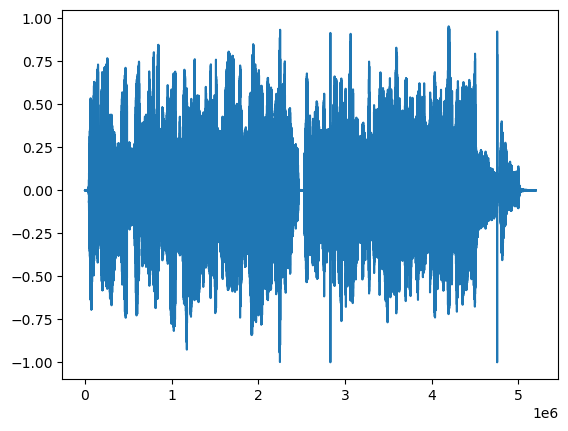

In [121]:
random_start = np.random.randint(0, len(data) - 1024)
y = data[random_start:random_start+1024]
y/=np.max(np.abs(y))
plt.plot(data)

In [38]:
clip_data = clip(threesec_data, 0.15)
Audio(clip_data, rate=16000)   

In [39]:
reconstructed = inpainting(clip_data, K=100, eps=1e-4, theta_clip=0.15, theta_max=0.8)

100%|██████████| 181/181 [08:12<00:00,  2.72s/it]


In [40]:
Audio(reconstructed, rate=16000)

In [55]:
compute_SNR_m(threesec_data, reconstructed,theta_clip=0.15)

0.03338052212523693

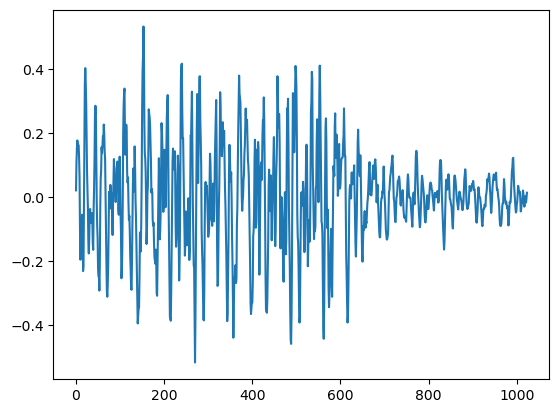

In [67]:
one_frame = data[120000 : 120000 + 1024]
plt.plot(one_frame)

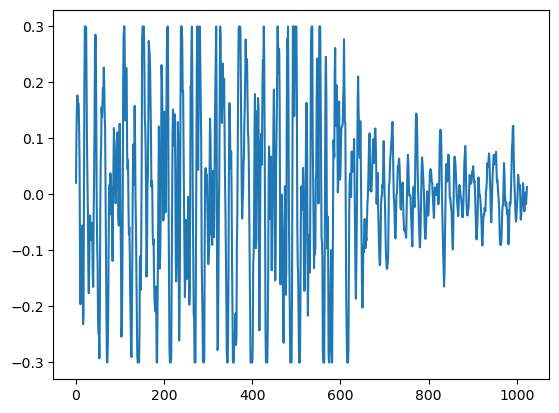

In [76]:
plt.plot(clip(one_frame, 0.3))

In [77]:
reconstruction = OMP(clip(one_frame, 0.3), 100, 1e-3, theta_clip=0.15, theta_max=0.8)[0]

Iteration 0: residual norm 5.04442.
Iteration 1: residual norm 4.91643.
Iteration 2: residual norm 4.73078.
Iteration 3: residual norm 4.54975.
Iteration 4: residual norm 4.46656.
Iteration 5: residual norm 4.28091.
Iteration 6: residual norm 4.07552.
Iteration 7: residual norm 3.77332.
Iteration 8: residual norm 3.62536.
Iteration 9: residual norm 3.42964.
Iteration 10: residual norm 3.34246.
Iteration 11: residual norm 3.21698.
Iteration 12: residual norm 3.12001.
Iteration 13: residual norm 2.99020.
Iteration 14: residual norm 2.88159.
Iteration 15: residual norm 2.75168.
Iteration 16: residual norm 2.63336.
Iteration 17: residual norm 2.52038.
Iteration 18: residual norm 2.43056.
Iteration 19: residual norm 2.36404.
Iteration 20: residual norm 2.28232.
Iteration 21: residual norm 2.20670.
Iteration 22: residual norm 2.14072.
Iteration 23: residual norm 2.06965.
Iteration 24: residual norm 1.99927.
Iteration 25: residual norm 1.93065.
Iteration 26: residual norm 1.87554.
Iteration 2

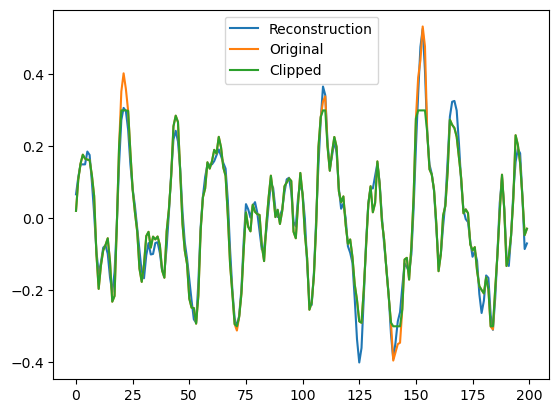

In [78]:
plt.plot(reconstruction[0:200], label='Reconstruction')
plt.plot(one_frame[0:200], label='Original') 
plt.plot(clip(one_frame, 0.3)[0:200], label='Clipped')
plt.legend()

In [79]:
compute_SNR_m(one_frame, reconstruction, theta_clip=0.3)

15.882169443200038

### Experiments : 

In [166]:
path_to_data = {"flute" : "processed_sounds/flute/",
                "saxophone" : "processed_sounds/saxophone/", "acoustic_guitar" : "processed_sounds/acoustic_guitar/", 
                "accordion" : "processed_sounds/accordion/","cello" : "processed_sounds/cello/"}

output_dir = "results/"

parameters_experiments = {
    "n_frames" : 10,
    "thetas_clip" : [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    "K" : 100
}

In [162]:
def compute_SNR_SDR(file_path, theta_clip, K, n_frames):
    """
    Inputs : 
    file_path : str
        Path to the file to be processed
    theta_clip : float
        Clipping threshold
    K : int
        Number of atoms to select
    n_frames : int
        Number of frames to process
        
    Outputs :
    SNRm : np.array
        Signal to Noise Ratio
    SDR : np.array
        Signal to Distortion Ratio
    """

    data = sf.read(file_path)[0]
    random_starts = np.random.randint(0, len(data) - 1024, n_frames)
    random_frames = [data[start:start+1024]/np.max(abs(data[start:start+1024])) for start in random_starts] #we normalize the frames' amplitudes
    clipped_random_frames = [clip(frame, theta_clip) for frame in random_frames]
    reconstructed_frames = [OMP(frame, K, 1e-3, theta_clip=theta_clip, theta_max=1.1, verbose = False)[0] for frame in clipped_random_frames]
    SNRm = [compute_SNR_m(frame, reconstruction, theta_clip=theta_clip) for frame, reconstruction in zip(random_frames, reconstructed_frames)]
    SDR = [compute_SDR(frame, clipped_frame, theta_clip=theta_clip) for frame, clipped_frame in zip(random_frames, clipped_random_frames)]
    return SNRm, SDR

In [163]:
def run_experiment(path_to_data, output_dir, parameters_experiments : dict):
    """
    Runs the inpainting experiment for each instrument in path_to_data, for different values of theta_clip
    For each theta_clip value, the experiment is repeated n_frames times, randomly selecting a different frame each time
    For each theta_clip value : n_frames / 2 frames from one wav file are used, n_frames / 2 frames from another wav file are used (same instrument)
    """

    thetas_clip = parameters_experiments["thetas_clip"]
    K = parameters_experiments["K"]
    n_frames = parameters_experiments["n_frames"]

    for instrument, path in tqdm(path_to_data.items()):
        print(f"Running experiment for {instrument}...")
        output_path = output_dir
        results = {}
        for theta_clip in thetas_clip:
            print(f"Running experiment for theta_clip = {theta_clip}...")

            SNRm1, SDR1 = compute_SNR_SDR(path + '1.wav', theta_clip, K, n_frames // 2)
            SNRm2, SDR2 = compute_SNR_SDR(path + '2.wav', theta_clip, K, n_frames // 2)

            mean_SNRm = np.mean(SNRm1 + SNRm2)
            std_SNRm = np.std(SNRm1 + SNRm2)
            mean_SDR = np.mean(SDR1 + SDR2)
            std_SDR = np.std(SDR1 + SDR2)

            results[theta_clip] = {"meanSNRm" : mean_SNRm, "meanSDR" : mean_SDR, "stdSNRm" : std_SNRm, "stdSDR" : std_SDR}

        output_file = os.path.join(output_path, f"result_{instrument}.txt")
        with open(output_file, "w") as f:
            f.write(str(results))

In [164]:
run_experiment(path_to_data, output_dir, parameters_experiments)

  0%|          | 0/5 [00:00<?, ?it/s]

Running experiment for cello...
Running experiment for theta_clip = 0.1...
Running experiment for theta_clip = 0.15...
Running experiment for theta_clip = 0.2...
Running experiment for theta_clip = 0.3...
Running experiment for theta_clip = 0.4...
Running experiment for theta_clip = 0.55...
Running experiment for theta_clip = 0.7...
Running experiment for theta_clip = 0.9...


 20%|██        | 1/5 [05:51<23:24, 351.02s/it]

Running experiment for flute...
Running experiment for theta_clip = 0.1...
Running experiment for theta_clip = 0.15...
Running experiment for theta_clip = 0.2...
Running experiment for theta_clip = 0.3...
Running experiment for theta_clip = 0.4...
Running experiment for theta_clip = 0.55...


 20%|██        | 1/5 [10:14<40:56, 614.04s/it]


SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.

### blabla

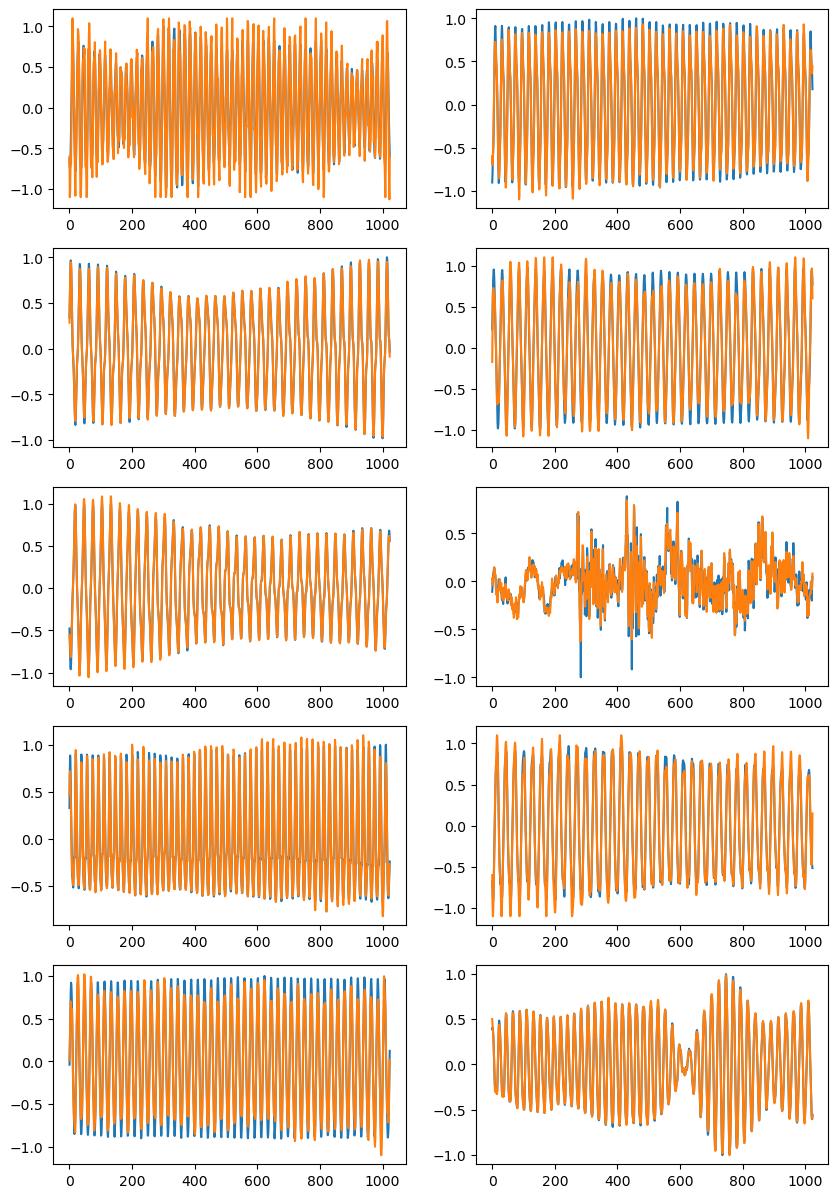

In [181]:
data = sf.read('processed_sounds/flute/1.wav')[0]
random_starts = np.random.randint(0, len(data) - 1024, 10)
random_frames = [data[start:start+1024]/np.max(abs(data[start:start+1024])) for start in random_starts]
fig, axes = plt.subplots(5, 2, figsize=(10, 15))
for i in range(5):
    axes[i, 0].plot(random_frames[i])
    axes[i,0].plot(OMP(random_frames[i], 100, 1e-3, theta_clip=0.6, theta_max=1.1, verbose = False)[0])
    axes[i, 1].plot(random_frames[i+5])
    axes[i,1].plot(OMP(random_frames[i+5], 100, 1e-3, theta_clip=0.6, theta_max=1.1, verbose = False)[0])